In [1]:
# path setup
import sys
import os
module_path = os.path.abspath(os.path.join('../../'))
sys.path.insert(1, module_path + "/utils")

## db setup
# pip install sqlalchemy
from sqlalchemy import create_engine
from getpass import getpass 

# pandas setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from modeling import lag_columns, extract_date_features
from data_from_db import get_table_from_shelter
from eda import print_correlation_matrix

In [2]:
df = get_table_from_shelter('shelter_climate')

#### focus on Toronto

In [3]:
df = df[df['location_city'] == 'Toronto']
df['capacity_units'] = df['taken_units'] + df['free_units']
df_model = df.copy()

### Question/Use-Case: Give predictions per overnight_shelter type on a monthly base 

#### start with warming shelter

In [4]:
warming_shelter = df[df['overnight_service_type'] == 'Warming Centre']
warming_shelter

,date,location_city,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,capacity_units
23,01.01.24,Toronto,Mixed Adult,Warming Centre,Bed,21.0,27.0,0.437500,0.562500,-3.1,0.1,-1.9,-0.7,2.0,48.0
42,01.01.24,Toronto,Mixed Adult,Warming Centre,Bed,41.0,5.0,0.891304,0.108696,-3.1,0.1,-1.9,-0.7,2.0,46.0
130,02.01.24,Toronto,Mixed Adult,Warming Centre,Bed,44.0,4.0,0.916667,0.083333,-1.5,0.0,0.0,1.5,0.0,48.0
149,02.01.24,Toronto,Mixed Adult,Warming Centre,Bed,44.0,2.0,0.956522,0.043478,-1.5,0.0,0.0,1.5,0.0,46.0
237,03.01.24,Toronto,Mixed Adult,Warming Centre,Bed,47.0,1.0,0.979167,0.020833,0.6,0.0,1.9,3.1,0.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127131,20.12.23,Toronto,Mixed Adult,Warming Centre,Bed,8.0,40.0,0.166667,0.833333,-1.0,0.0,1.7,4.4,0.0,48.0
127233,21.12.23,Toronto,Mixed Adult,Warming Centre,Bed,2.0,46.0,0.041667,0.958333,-3.6,0.0,-0.3,3.1,0.0,48.0
128265,31.12.23,Toronto,Mixed Adult,Warming Centre,Bed,13.0,35.0,0.270833,0.729167,-1.0,2.3,0.3,1.6,0.0,48.0
128284,31.12.23,Toronto,Mixed Adult,Warming Centre,Bed,19.0,27.0,0.413043,0.586957,-1.0,2.3,0.3,1.6,0.0,46.0


In [5]:
agg_functions = {
    'taken_units': 'sum',
    'free_units': 'sum',
    'capacity_units': 'sum',
    'min_temperature': 'mean',
    'total_precipitation': 'mean',
    'mean_temperature': 'mean',
    'max_temperature': 'mean',
    'snow_on_ground': 'mean'
}

warming_daily = warming_shelter.groupby('date').agg(agg_functions).reset_index()


In [6]:
warming_daily = extract_date_features(warming_daily, 'date')

/Users/jeanneendres/Documents/Ironhack/Projects/Predicting_Shelter_Availability/utils/modeling.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_column] = pd.to_datetime(df[date_column])


In [7]:
warming_daily

,date,taken_units,free_units,capacity_units,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,year,month,day,day_of_week
1,2021-01-02,112.0,3.0,115.0,-9.6,0.0,-5.8,-2.0,4.0,2021,1,2,6
5,2021-01-03,41.0,59.0,100.0,-9.6,0.0,-1.5,6.5,1.0,2021,1,3,7
9,2021-01-04,8.0,0.0,8.0,-1.7,0.0,0.7,3.1,0.0,2021,1,4,1
320,2021-01-22,44.0,53.0,97.0,-6.4,0.3,-1.9,2.6,0.0,2021,1,22,5
335,2021-01-23,93.0,4.0,97.0,-10.6,0.0,-7.3,-4.0,0.0,2021,1,23,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2024-11-02,40.0,8.0,48.0,1.9,0.0,2.9,3.9,0.0,2024,11,2,6
160,2024-11-03,53.0,10.0,63.0,-0.8,0.0,3.8,8.4,0.0,2024,11,3,7
168,2024-12-01,91.0,3.0,94.0,-0.1,11.8,1.9,3.9,0.0,2024,12,1,7
171,2024-12-02,39.0,9.0,48.0,-0.3,0.0,1.8,3.9,0.0,2024,12,2,1


In [8]:
# Calculate monthly averages
monthly_averages = warming_daily.groupby([warming_daily['date'].dt.month]).agg({
    'min_temperature': 'mean',
    'total_precipitation': 'mean',
    'mean_temperature': 'mean',
    'max_temperature': 'mean',
    'snow_on_ground': 'mean',
    'taken_units': 'sum',
    'free_units': 'sum',
    'capacity_units': 'sum'
}).reset_index()
monthly_averages.rename(columns={'date': 'month'}, inplace=True)
monthly_averages

,month,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,taken_units,free_units,capacity_units
0,1,-6.732432,1.983784,-3.393243,-0.050000,6.675676,6725.0,608.0,7333.0
1,2,-4.971053,2.317105,-1.189474,2.592105,6.197368,7404.0,492.0,7896.0
2,3,-0.563333,2.402222,3.143333,6.854444,1.355556,6291.0,443.0,6734.0
3,4,2.278947,1.557895,6.478947,10.660526,1.552632,2602.0,69.0,2671.0
4,5,4.615385,1.430769,8.738462,12.853846,2.038462,1794.0,61.0,1855.0
5,6,-0.006250,0.943750,3.000000,6.018750,2.687500,1072.0,110.0,1182.0
6,7,-1.168750,0.737500,1.850000,4.900000,3.000000,1134.0,224.0,1358.0
7,8,-0.700000,0.275000,2.781250,6.256250,2.375000,1167.0,85.0,1252.0
8,9,1.487500,5.368750,4.981250,8.456250,2.187500,1114.0,120.0,1234.0
9,10,0.626667,0.660000,4.260000,7.906667,2.000000,1125.0,123.0,1248.0


In [9]:
monthly_averages.describe().T

,count,mean,std,min,25%,50%,75%,max
month,12.0,6.500000,3.605551,1.000000,3.750000,6.500000,9.250000,12.000000
min_temperature,12.0,-0.499254,3.014004,-6.732432,-1.180510,-0.284792,0.841875,4.615385
total_precipitation,12.0,1.943198,1.389313,0.275000,0.892188,1.770839,2.408118,5.368750
mean_temperature,12.0,3.053008,3.193986,-3.393243,1.978289,3.071667,4.440313,8.738462
max_temperature,12.0,6.605598,3.400802,-0.050000,5.160526,6.555347,8.044062,12.853846
snow_on_ground,12.0,2.696173,1.844596,1.026316,1.503363,2.112981,2.765625,6.675676
taken_units,12.0,2852.500000,2440.289607,1072.000000,1131.750000,1823.500000,3524.250000,7404.000000
free_units,12.0,269.250000,232.346186,61.000000,103.750000,150.000000,455.250000,719.000000
capacity_units,12.0,3121.750000,2595.835165,1182.000000,1251.000000,1990.500000,3686.750000,7896.000000


In [10]:
correlation_matrix = monthly_averages.corr()

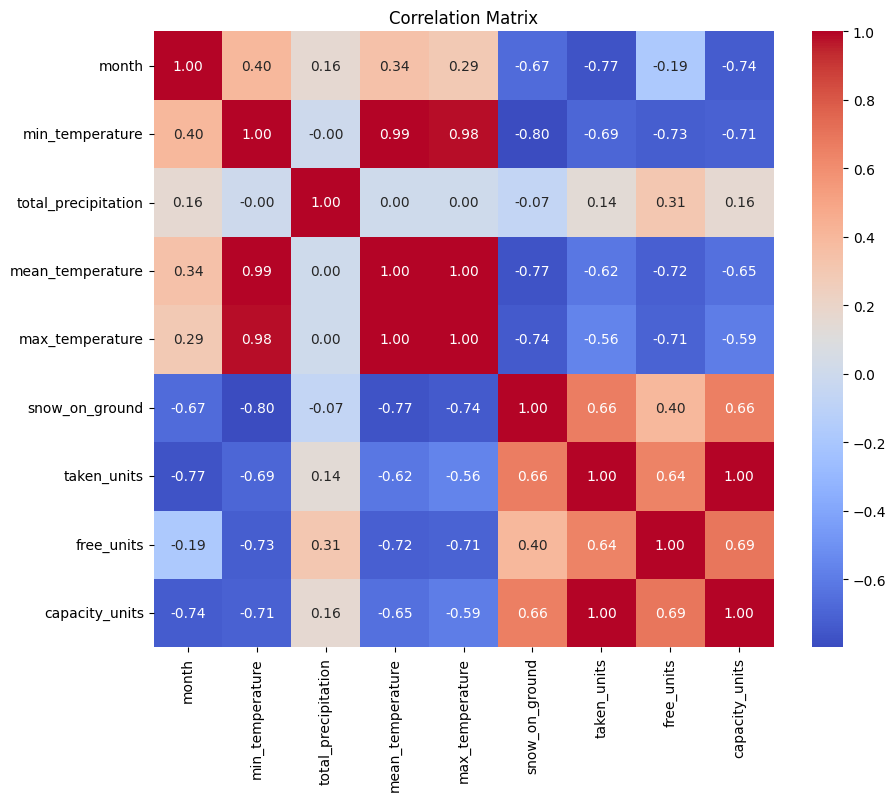

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [12]:
display(correlation_matrix)

,month,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,taken_units,free_units,capacity_units
month,1.000000,0.401164,0.160753,0.344379,0.291051,-0.666969,-0.765143,-0.185185,-0.735870
min_temperature,0.401164,1.000000,-0.002900,0.994281,0.980088,-0.799445,-0.688060,-0.728779,-0.712062
total_precipitation,0.160753,-0.002900,1.000000,0.002050,0.004087,-0.065883,0.141927,0.305839,0.160797
mean_temperature,0.344379,0.994281,0.002050,1.000000,0.995685,-0.771070,-0.623397,-0.720623,-0.650544
max_temperature,0.291051,0.980088,0.004087,0.995685,1.000000,-0.738890,-0.561188,-0.707559,-0.590893
snow_on_ground,-0.666969,-0.799445,-0.065883,-0.771070,-0.738890,1.000000,0.662614,0.396054,0.658359
taken_units,-0.765143,-0.688060,0.141927,-0.623397,-0.561188,0.662614,1.000000,0.643186,0.997649
free_units,-0.185185,-0.728779,0.305839,-0.720623,-0.707559,0.396054,0.643186,1.000000,0.694152
capacity_units,-0.735870,-0.712062,0.160797,-0.650544,-0.590893,0.658359,0.997649,0.694152,1.000000


In [13]:
correlation_matrix['capacity_units'].abs().sort_values(ascending=False)

capacity_units         1.000000
taken_units            0.997649
month                  0.735870
min_temperature        0.712062
free_units             0.694152
snow_on_ground         0.658359
mean_temperature       0.650544
max_temperature        0.590893
total_precipitation    0.160797
Name: capacity_units, dtype: float64

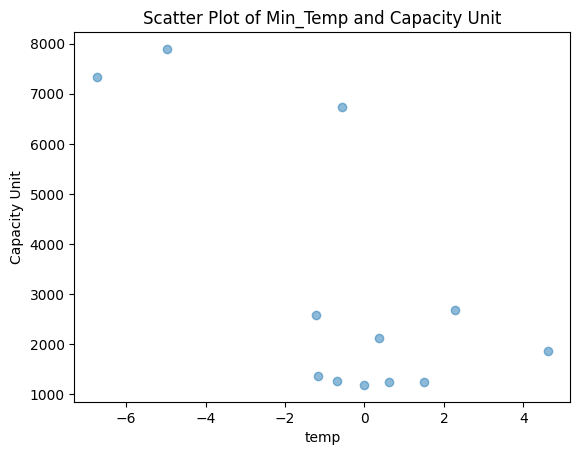

In [14]:
temp = monthly_averages['min_temperature']
capacity_unit = monthly_averages['capacity_units']

# Create scatter plot
plt.scatter(temp, capacity_unit, alpha=0.5)
plt.title('Scatter Plot of Min_Temp and Capacity Unit')
plt.xlabel('temp')
plt.ylabel('Capacity Unit')
plt.show()

In [15]:
monthly_averages = monthly_averages[['month', 'min_temperature','total_precipitation','snow_on_ground','capacity_units']]

In [16]:
correlation_matrix = monthly_averages.corr()
correlation_matrix['capacity_units'].abs().sort_values(ascending=False)

capacity_units         1.000000
month                  0.735870
min_temperature        0.712062
snow_on_ground         0.658359
total_precipitation    0.160797
Name: capacity_units, dtype: float64

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = monthly_averages[['min_temperature', 'total_precipitation', 'snow_on_ground']]
y = monthly_averages['capacity_units']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

score = model.score(X_test, y_test)
print("R^2 Score:", score)

Mean Absolute Error: 441.9045212922958
R^2 Score: 0.9569125868808727


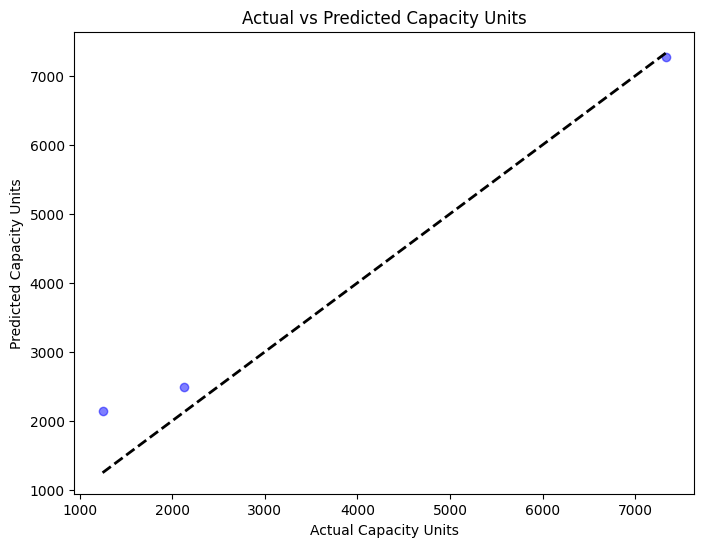

In [18]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Plotting the diagonal line
plt.title('Actual vs Predicted Capacity Units')
plt.xlabel('Actual Capacity Units')
plt.ylabel('Predicted Capacity Units')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = monthly_averages[['month','min_temperature', 'total_precipitation', 'snow_on_ground']]
y = monthly_averages['capacity_units']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

score = model.score(X_test, y_test)
print("R^2 Score:", score)

Mean Absolute Error: 1677.2324678476425
R^2 Score: 0.6028397221822384


In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
taken_units,105447.0,47.202339,48.834709,1.0000,19.0,34.0,57.0,330.0000
free_units,105447.0,0.700039,2.921603,-1.0000,0.0,0.0,0.0,97.0000
capacity_rate,105447.0,0.974391,0.081982,0.0200,1.0,1.0,1.0,1.0125
availability,105447.0,0.025609,0.081982,-0.0125,0.0,0.0,0.0,0.9800
min_temperature,105447.0,5.962327,9.483483,-20.5000,-0.9,5.3,14.8,24.1000
total_precipitation,105447.0,2.114105,5.420392,0.0000,0.0,0.0,1.3,50.1000
mean_temperature,105447.0,9.728626,9.890973,-16.5000,1.9,9.0,19.2,28.6000
max_temperature,105447.0,13.492939,10.523203,-12.6000,4.4,12.8,23.4,35.8000
snow_on_ground,105447.0,1.392738,4.216608,0.0000,0.0,0.0,0.0,32.0000
capacity_units,105447.0,47.902377,48.794116,1.0000,19.0,35.0,58.0,330.0000


> too little data in the set

#### no filtering by overnight_service_type

In [21]:
by_month = extract_date_features(df, 'date')
by_month

/Users/jeanneendres/Documents/Ironhack/Projects/Predicting_Shelter_Availability/utils/modeling.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_column] = pd.to_datetime(df[date_column])


,date,location_city,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,capacity_units,year,month,day,day_of_week
9719,2021-01-01,Toronto,Mixed Adult,Shelter,Bed,6.0,2.0,0.750000,0.250000,-1.0,6.8,0.7,2.5,0.0,8.0,2021,1,1,5
9784,2021-01-01,Toronto,Mixed Adult,24-Hour Respite Site,Bed,24.0,1.0,0.960000,0.040000,-1.0,6.8,0.7,2.5,0.0,25.0,2021,1,1,5
9783,2021-01-01,Toronto,Youth,Shelter,Bed,10.0,3.0,0.769231,0.230769,-1.0,6.8,0.7,2.5,0.0,13.0,2021,1,1,5
9782,2021-01-01,Toronto,Youth,Motel/Hotel Shelter,Room,20.0,2.0,0.909091,0.090909,-1.0,6.8,0.7,2.5,0.0,22.0,2021,1,1,5
9781,2021-01-01,Toronto,Youth,Shelter,Bed,16.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,16.0,2021,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7627,2024-12-03,Toronto,Women,Shelter,Bed,88.0,0.0,1.000000,0.000000,2.6,0.0,8.3,14.0,0.0,88.0,2024,12,3,2
7626,2024-12-03,Toronto,Mixed Adult,Motel/Hotel Shelter,Room,63.0,1.0,0.984375,0.015625,2.6,0.0,8.3,14.0,0.0,64.0,2024,12,3,2
7625,2024-12-03,Toronto,Men,Shelter,Bed,105.0,0.0,1.000000,0.000000,2.6,0.0,8.3,14.0,0.0,105.0,2024,12,3,2
7623,2024-12-03,Toronto,Men,Shelter,Bed,21.0,0.0,1.000000,0.000000,2.6,0.0,8.3,14.0,0.0,21.0,2024,12,3,2


In [22]:
numeric_data = by_month.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()

In [23]:
correlation_matrix['capacity_units'].abs().sort_values(ascending=False)

capacity_units         1.000000
taken_units            0.998209
year                   0.162298
availability           0.131662
capacity_rate          0.131662
max_temperature        0.018752
free_units             0.016039
mean_temperature       0.015830
min_temperature        0.012206
snow_on_ground         0.012160
month                  0.010697
day                    0.007011
total_precipitation    0.002278
day_of_week            0.000421
Name: capacity_units, dtype: float64

> **realised that it will always only be 12 rows when i aggregate..**

#### instead: try utilizing extracted months 
- build a model that checks the month column -- make the time so small that it seems linear

In [24]:
df_model

,date,location_city,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,capacity_units
0,01.01.24,Toronto,Families,Motel/Hotel Shelter,Room,149.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,149.0
1,01.01.24,Toronto,Mixed Adult,Motel/Hotel Shelter,Room,57.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,57.0
2,01.01.24,Toronto,Mixed Adult,Shelter,Bed,8.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,8.0
3,01.01.24,Toronto,Families,Motel/Hotel Shelter,Room,67.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,67.0
4,01.01.24,Toronto,Families,Motel/Hotel Shelter,Room,161.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128342,31.12.23,Toronto,Youth,Shelter,Bed,40.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,40.0
128343,31.12.23,Toronto,Women,Shelter,Bed,30.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,30.0
128344,31.12.23,Toronto,Youth,Shelter,Bed,31.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,31.0
128345,31.12.23,Toronto,Women,Shelter,Bed,27.0,1.0,0.964286,0.035714,-1.0,2.3,0.3,1.6,0.0,28.0


In [25]:
df_model.drop(columns='location_city', inplace=True)
df_model

,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,capacity_units
0,01.01.24,Families,Motel/Hotel Shelter,Room,149.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,149.0
1,01.01.24,Mixed Adult,Motel/Hotel Shelter,Room,57.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,57.0
2,01.01.24,Mixed Adult,Shelter,Bed,8.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,8.0
3,01.01.24,Families,Motel/Hotel Shelter,Room,67.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,67.0
4,01.01.24,Families,Motel/Hotel Shelter,Room,161.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128342,31.12.23,Youth,Shelter,Bed,40.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,40.0
128343,31.12.23,Women,Shelter,Bed,30.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,30.0
128344,31.12.23,Youth,Shelter,Bed,31.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,31.0
128345,31.12.23,Women,Shelter,Bed,27.0,1.0,0.964286,0.035714,-1.0,2.3,0.3,1.6,0.0,28.0


#### filter for specific month

- extract dates

In [26]:
df_model = extract_date_features(df_model, 'date')
df_model

/Users/jeanneendres/Documents/Ironhack/Projects/Predicting_Shelter_Availability/utils/modeling.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_column] = pd.to_datetime(df[date_column])


,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,capacity_units,year,month,day,day_of_week
9719,2021-01-01,Mixed Adult,Shelter,Bed,6.0,2.0,0.750000,0.250000,-1.0,6.8,0.7,2.5,0.0,8.0,2021,1,1,5
9784,2021-01-01,Mixed Adult,24-Hour Respite Site,Bed,24.0,1.0,0.960000,0.040000,-1.0,6.8,0.7,2.5,0.0,25.0,2021,1,1,5
9783,2021-01-01,Youth,Shelter,Bed,10.0,3.0,0.769231,0.230769,-1.0,6.8,0.7,2.5,0.0,13.0,2021,1,1,5
9782,2021-01-01,Youth,Motel/Hotel Shelter,Room,20.0,2.0,0.909091,0.090909,-1.0,6.8,0.7,2.5,0.0,22.0,2021,1,1,5
9781,2021-01-01,Youth,Shelter,Bed,16.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,16.0,2021,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7627,2024-12-03,Women,Shelter,Bed,88.0,0.0,1.000000,0.000000,2.6,0.0,8.3,14.0,0.0,88.0,2024,12,3,2
7626,2024-12-03,Mixed Adult,Motel/Hotel Shelter,Room,63.0,1.0,0.984375,0.015625,2.6,0.0,8.3,14.0,0.0,64.0,2024,12,3,2
7625,2024-12-03,Men,Shelter,Bed,105.0,0.0,1.000000,0.000000,2.6,0.0,8.3,14.0,0.0,105.0,2024,12,3,2
7623,2024-12-03,Men,Shelter,Bed,21.0,0.0,1.000000,0.000000,2.6,0.0,8.3,14.0,0.0,21.0,2024,12,3,2


#### add lagged data

In [42]:
def add_lagged_columns(df, date_column, columns_to_lag, lag_column_name):
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Group the DataFrame by date and calculate the mean for each specified column
    daily_mean_temp_df = df.groupby(df[date_column].dt.date)[columns_to_lag].mean().reset_index()
    
    # Create a new DataFrame for lagged columns
    lagged_columns_df = pd.DataFrame()
    
    # Create lagged columns for each specified column
    for column in columns_to_lag:
        # Calculate the lagged values
        lagged_column_name = f"{column}_{lag_column_name}"
        daily_mean_temp_df[lagged_column_name] = daily_mean_temp_df[column].shift(1)
        # Fill NaN values with the first value of the column
        daily_mean_temp_df[lagged_column_name].fillna(daily_mean_temp_df[column].iloc[0], inplace=True)
        
        # Add lagged column to lagged_columns_df
        lagged_columns_df[lagged_column_name] = daily_mean_temp_df[lagged_column_name]
    
    return lagged_columns_df 

In [38]:
columns_to_lag = ['mean_temperature','snow_on_ground', 'capacity_units']
lagged_data = add_lagged_columns(df_model, 'date', columns_to_lag, '_1')
display(lagged_data.isna().sum().sum())
lagged_data

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_39809/821726000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_column] = pd.to_datetime(df[date_column])


0

,mean_temperature__1,snow_on_ground__1,capacity_units__1
0,0.7,0.0,35.620690
1,0.7,0.0,35.620690
2,-3.9,3.0,34.755556
3,-5.9,1.0,34.923913
4,0.7,0.0,33.844444
...,...,...,...
99,-7.8,0.0,63.600000
100,0.8,0.0,63.544444
101,5.2,0.0,63.377778
102,8.2,0.0,63.255556


In [41]:
df_model.reset_index(inplace=True)
df_model = pd.concat([df_model, lagged_data], axis=1)

ValueError: cannot insert level_0, already exists

In [30]:
df_model = df_model[df_model['month'] == 2]
df_model

,index,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,...,max_temperature,snow_on_ground,capacity_units,year,month,day,day_of_week,mean_temperature__1,snow_on_ground__1,capacity_units__1
2773,9826,2021-02-01,Mixed Adult,Shelter,Bed,6.0,2.0,0.750000,0.250000,-0.9,...,2.2,0.0,8.0,2021,2,1,1,NaN,NaN,NaN
2774,9921,2021-02-01,Youth,Motel/Hotel Shelter,Room,21.0,1.0,0.954545,0.045455,-0.9,...,2.2,0.0,22.0,2021,2,1,1,NaN,NaN,NaN
2775,9895,2021-02-01,Women,Shelter,Bed,18.0,0.0,1.000000,0.000000,-0.9,...,2.2,0.0,18.0,2021,2,1,1,NaN,NaN,NaN
2776,9894,2021-02-01,Youth,Motel/Hotel Shelter,Room,9.0,0.0,1.000000,0.000000,-0.9,...,2.2,0.0,9.0,2021,2,1,1,NaN,NaN,NaN
2777,9893,2021-02-01,Youth,Shelter,Bed,6.0,3.0,0.666667,0.333333,-0.9,...,2.2,0.0,9.0,2021,2,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101054,6338,2024-02-29,Youth,Shelter,Bed,93.0,1.0,0.989362,0.010638,-5.9,...,-1.1,0.0,94.0,2024,2,29,4,NaN,NaN,NaN
101055,6337,2024-02-29,Men,Shelter,Bed,28.0,0.0,1.000000,0.000000,-5.9,...,-1.1,0.0,28.0,2024,2,29,4,NaN,NaN,NaN
101056,6336,2024-02-29,Women,Shelter,Bed,88.0,0.0,1.000000,0.000000,-5.9,...,-1.1,0.0,88.0,2024,2,29,4,NaN,NaN,NaN
101057,6335,2024-02-29,Mixed Adult,Motel/Hotel Shelter,Room,65.0,0.0,1.000000,0.000000,-5.9,...,-1.1,0.0,65.0,2024,2,29,4,NaN,NaN,NaN


- check correlation matrix numerical 

In [31]:
numerical = df_model.select_dtypes(include=['number'])
numerical

,index,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,capacity_units,year,month,day,day_of_week,mean_temperature__1,snow_on_ground__1,capacity_units__1
2773,9826,6.0,2.0,0.750000,0.250000,-0.9,10.8,0.7,2.2,0.0,8.0,2021,2,1,1,NaN,NaN,NaN
2774,9921,21.0,1.0,0.954545,0.045455,-0.9,10.8,0.7,2.2,0.0,22.0,2021,2,1,1,NaN,NaN,NaN
2775,9895,18.0,0.0,1.000000,0.000000,-0.9,10.8,0.7,2.2,0.0,18.0,2021,2,1,1,NaN,NaN,NaN
2776,9894,9.0,0.0,1.000000,0.000000,-0.9,10.8,0.7,2.2,0.0,9.0,2021,2,1,1,NaN,NaN,NaN
2777,9893,6.0,3.0,0.666667,0.333333,-0.9,10.8,0.7,2.2,0.0,9.0,2021,2,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101054,6338,93.0,1.0,0.989362,0.010638,-5.9,0.0,-3.5,-1.1,0.0,94.0,2024,2,29,4,NaN,NaN,NaN
101055,6337,28.0,0.0,1.000000,0.000000,-5.9,0.0,-3.5,-1.1,0.0,28.0,2024,2,29,4,NaN,NaN,NaN
101056,6336,88.0,0.0,1.000000,0.000000,-5.9,0.0,-3.5,-1.1,0.0,88.0,2024,2,29,4,NaN,NaN,NaN
101057,6335,65.0,0.0,1.000000,0.000000,-5.9,0.0,-3.5,-1.1,0.0,65.0,2024,2,29,4,NaN,NaN,NaN


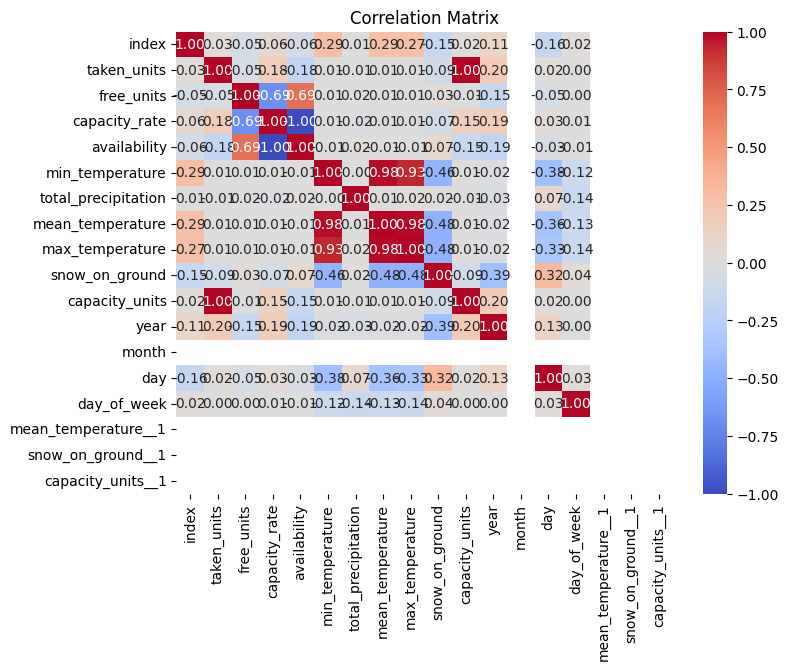

In [32]:
print_correlation_matrix(numerical)

In [33]:
correlation_matrix = numeric_data.corr()
correlation_matrix['capacity_units'].abs().sort_values(ascending=False)

capacity_units         1.000000
taken_units            0.998209
year                   0.162298
availability           0.131662
capacity_rate          0.131662
max_temperature        0.018752
free_units             0.016039
mean_temperature       0.015830
min_temperature        0.012206
snow_on_ground         0.012160
month                  0.010697
day                    0.007011
total_precipitation    0.002278
day_of_week            0.000421
Name: capacity_units, dtype: float64

- add lag data

-- remove columns with low correlation

In [34]:
df_model = df_model[['date','year','mean_temperature','snow_on_ground', 'capacity_units']]
df_model

,date,year,mean_temperature,snow_on_ground,capacity_units
2773,2021-02-01,2021,0.7,0.0,8.0
2774,2021-02-01,2021,0.7,0.0,22.0
2775,2021-02-01,2021,0.7,0.0,18.0
2776,2021-02-01,2021,0.7,0.0,9.0
2777,2021-02-01,2021,0.7,0.0,9.0
...,...,...,...,...,...
101054,2024-02-29,2024,-3.5,0.0,94.0
101055,2024-02-29,2024,-3.5,0.0,28.0
101056,2024-02-29,2024,-3.5,0.0,88.0
101057,2024-02-29,2024,-3.5,0.0,65.0


In [35]:
def check_lag_consistency(df, date_column):
    avg_mean_temp = df.groupby(date_column)['mean_temperature'].mean()
    lagged_temp = df.groupby(date_column)['mean_temperature_lag_1'].first()
    consistency_mask = (avg_mean_temp == lagged_temp)
    return consistency_mask

In [36]:
check_lag_consistency(df_model, 'date').sum()

KeyError: 'Column not found: mean_temperature_lag_1'

- check correlation categorical and numerical

- select features, remove rest

- train-test-split

- normalize categorical

- scale numerical

- train model